(array([ 2.,  0.,  0.,  1.,  1.,  2.,  0.,  2.,  2.,  0.,  2.,  2.,  2.,
         2.,  3.,  1.,  2.,  3.,  5.,  6.,  6.,  4.,  9.,  5.,  6.,  3.,
        14., 11., 15.,  6., 11., 10., 12., 21., 20., 17., 15., 17., 16.,
        23., 15., 27., 22., 23., 30., 22., 17., 19., 32., 26., 19., 27.,
        23., 23., 18., 17., 17., 27., 20., 19., 18., 22., 13., 18., 22.,
        22., 13., 16., 13., 11., 13., 10.,  8.,  4., 11., 11.,  8.,  4.,
         6.,  1.,  4.,  2.,  4.,  4.,  3.,  4.,  0.,  1.,  3.,  1.,  2.,
         0.,  0.,  1.,  0.,  0.,  0.,  1.,  3.,  1.]),
 array([0.19961658, 0.20562791, 0.21163925, 0.21765059, 0.22366193,
        0.22967326, 0.2356846 , 0.24169594, 0.24770728, 0.25371861,
        0.25972995, 0.26574129, 0.27175263, 0.27776396, 0.2837753 ,
        0.28978664, 0.29579798, 0.30180932, 0.30782065, 0.31383199,
        0.31984333, 0.32585467, 0.331866  , 0.33787734, 0.34388868,
        0.34990002, 0.35591135, 0.36192269, 0.36793403, 0.37394537,
        0.3799567 , 0.3859

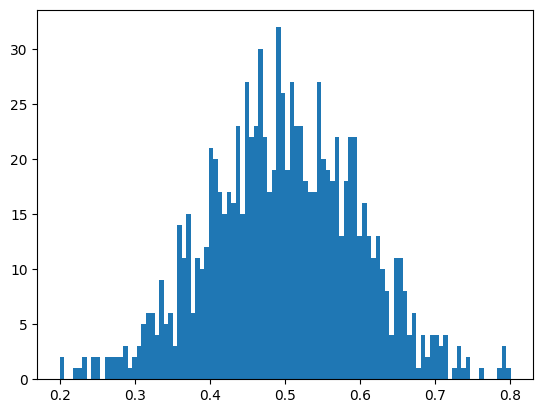

In [70]:
import numpy as np
import matplotlib.pyplot as plt

# Number of agents
N = 1000

# Wealth
wealth_arr = abs(np.random.normal(0.5, 0.1, N))
plt.hist(wealth_arr, bins=100)  

(array([85., 63., 69., 52., 56., 55., 61., 44., 30., 35., 40., 23., 39.,
        26., 26., 25., 26., 13., 13., 17., 13., 20., 12., 14., 13., 11.,
         7., 11.,  7.,  7.,  6.,  8.,  4.,  5.,  2.,  6.,  3.,  5.,  8.,
         1.,  3.,  1.,  3.,  3.,  6.,  2.,  0.,  2.,  4.,  1.,  0.,  0.,
         0.,  3.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  3.,  1.,  1.,
         1.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.]),
 array([8.47245341e-04, 4.28028267e-02, 8.47584081e-02, 1.26713989e-01,
        1.68669571e-01, 2.10625152e-01, 2.52580734e-01, 2.94536315e-01,
        3.36491896e-01, 3.78447478e-01, 4.20403059e-01, 4.62358641e-01,
        5.04314222e-01, 5.46269803e-01, 5.88225385e-01, 6.30180966e-01,
        6.72136547e-01, 7.14092129e-01, 7.56047710e-01, 7.98003292e-01,
        8.39958873e-01, 8.81914454e-01, 9.23870036e-01, 9.65825617e-01,
  

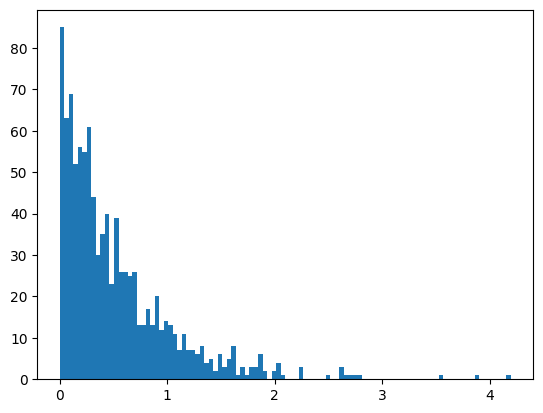

In [71]:
import random
N = 1000
alpha = 1
beta = 0.5

wealth_arr = np.array([random.gammavariate(alpha, beta) for i in range(N)])
plt.hist(wealth_arr, bins=100)

In [85]:
def gini(arr):
    ## first sort
    sorted_arr = arr.copy()
    sorted_arr.sort()
    n = arr.size
    coef_ = 2. / n
    const_ = (n + 1.) / n
    weighted_sum = sum([(i+1)*yi for i, yi in enumerate(sorted_arr)])
    return coef_*weighted_sum/(sorted_arr.sum()) - const_

gini(wealth_arr)

np.float64(0.5000025560293613)

In [73]:
X = wealth_arr
X_lorenz = X.cumsum() / X.sum()
X_lorenz = np.insert(X_lorenz, 0, 0)
X_lorenz[0], X_lorenz[-1]


(np.float64(0.0), np.float64(0.9999999999999993))

Text(0.5, 1.0, 'Lorenz curve')

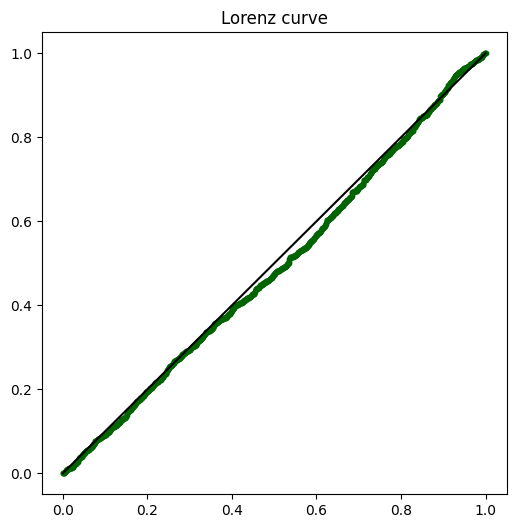

In [74]:
fig, ax = plt.subplots(figsize=[6,6])

ax.scatter(np.arange(X_lorenz.size)/(X_lorenz.size-1), X_lorenz, color='darkgreen', s=10)
ax.plot([0,1], [0,1], color='k')
ax.set_title('Lorenz curve')
 

In [75]:
from mesa import Model, Agent
from mesa.time import RandomActivation
from mesa.datacollection import DataCollector

class PotentialCriminal(Agent):
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = model.wealth_arr[unique_id]
        self.criminal = False
        self.wealth = model.wealth_arr[unique_id]
        
    def step(self):
        if self.criminal:  
            return

        other_agent = self.random.choice(self.model.schedule.agents)

        if other_agent.wealth - self.wealth > self.model.deterrence:
            self.criminal = True

            stolen_amount = self.random.random() * other_agent.wealth
            self.wealth += stolen_amount 
            other_agent.wealth -= stolen_amount
        
        return

def get_crime_rate(model):
    agent_out = [agent.criminal for agent in model.schedule.agents]
    return sum(agent_out)/model.num_agents
    

class CrimeModel(Model):
    def __init__(self, N, deterrence, wealth_arr):
        self.num_agents = N
        self.deterrence = deterrence
        self.wealth_arr = wealth_arr
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
            model_reporters={"Crime rate": get_crime_rate},
            agent_reporters={"Criminal": "criminal", "Wealth": "wealth"}
        )
        
        for i in range(self.num_agents):
            a = PotentialCriminal(i, self)
            self.schedule.add(a)
    
    def crime_rate(self):
        return sum([a.criminal for a in self.schedule.agents])/self.num_agents
            
    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [76]:
model = CrimeModel(N, 0.8, wealth_arr)

while model.schedule.steps < 1000:
    model.step()


C:\Users\nxg05271\AppData\Local\Temp\ipykernel_32180\2854728552.py:7: FutureWarning: The Mesa Model class was not initialized. In the future, you need to explicitly initialize the Model by calling super().__init__() on initialization.
  super().__init__(unique_id, model)


In [77]:
model.datacollector.get_agent_vars_dataframe()

Criminal    Wealth
Step AgentID                    
0    0           False  0.015592
     1           False  0.468261
     2           False  0.113743
     3           False  0.653691
     4           False  0.632036
...                ...       ...
999  936          True  0.769698
     509          True  0.483992
     557          True  0.707793
     787          True  0.600255
     100          True  0.729802

[1000000 rows x 2 columns]

In [78]:
model.datacollector.get_model_vars_dataframe()

,Crime rate
0,0.000
1,0.097
2,0.169
3,0.233
4,0.298
...,...
995,0.650
996,0.650
997,0.650
998,0.650


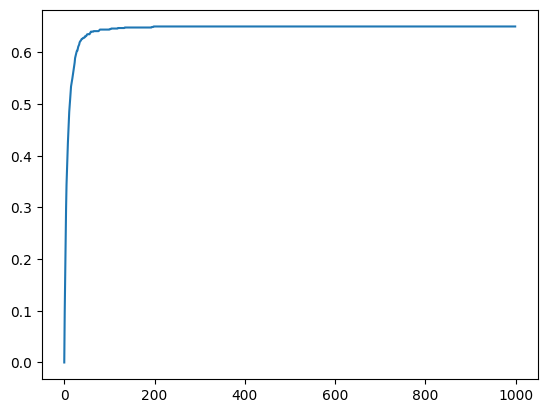

In [79]:
plt.plot(model.datacollector.get_model_vars_dataframe())

In [83]:
df_explo = model.datacollector.get_agent_vars_dataframe().reset_index()
df_explo

,Step,AgentID,Criminal,Wealth
0,0,0,False,0.015592
1,0,1,False,0.468261
2,0,2,False,0.113743
3,0,3,False,0.653691
4,0,4,False,0.632036
...,...,...,...,...
999995,999,936,True,0.769698
999996,999,509,True,0.483992
999997,999,557,True,0.707793
999998,999,787,True,0.600255


(array([ 2.,  4.,  5.,  1.,  9.,  5.,  4.,  5.,  1.,  3.,  6.,  4.,  9.,
         4.,  3.,  5.,  5.,  5.,  9.,  6.,  7., 15., 11.,  7.,  5., 14.,
         9., 16.,  7.,  9., 15., 16., 13.,  5., 15., 11., 10.,  9.,  8.,
        16., 11., 13., 13., 12., 18., 10., 14., 13., 14., 17., 12., 11.,
        20., 13., 16., 21., 17., 13., 11., 11., 16., 14., 10., 15., 23.,
        22., 14., 19., 15., 12., 15.,  8.,  7., 16., 12.,  7., 15., 17.,
        14., 10.,  9., 15.,  8., 12., 16.,  8.,  4.,  9.,  9.,  5.,  8.,
         3.,  6.,  2.,  4.,  3.,  1.,  0.,  2.,  2.]),
 array([0.00450567, 0.01439491, 0.02428416, 0.0341734 , 0.04406265,
        0.0539519 , 0.06384114, 0.07373039, 0.08361963, 0.09350888,
        0.10339812, 0.11328737, 0.12317661, 0.13306586, 0.1429551 ,
        0.15284435, 0.1627336 , 0.17262284, 0.18251209, 0.19240133,
        0.20229058, 0.21217982, 0.22206907, 0.23195831, 0.24184756,
        0.25173681, 0.26162605, 0.2715153 , 0.28140454, 0.29129379,
        0.30118303, 0.3110

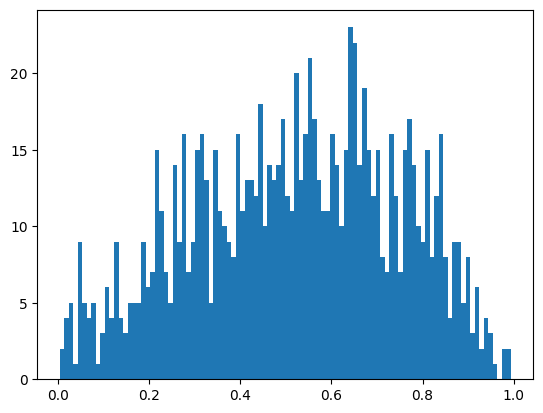

In [84]:
plt.hist(df_explo.loc[df_explo.Step == 999, 'Wealth'], bins=100)